In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/home/richard/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
import chaospy
import corner
import torch
import warnings
import pickle

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

# Sampling a 2d correlated Gaussian

In [2]:
# Let's begin by obtaining some prior samples. I've chosen Unif(-1, 1) in all dimensions.

n = 2 # Number of dimensions.
n_prior = 50 # Number of prior samples
# Note the use of the key here. Jax uses this as opposed to your normal random seed. 
jax_prior_init = jax.random.uniform(key, shape=(n_prior, n), minval=-5, maxval=5)

In [3]:
'''
This is just a function to generate a covariance matrix for the Gaussian as a random sample from a Wishart
distribution, whilst ensuring the condition number is not too high.
'''
def get_icov(n, target=200, iseed=seed, eps=1, scale=50, just_do_it=False):
    condition = 0
    eigmax = np.inf
    this_seed = iseed
    if just_do_it:
        wish = scipy.stats.wishart(df=n, scale=np.eye(n)*scale, seed=this_seed)
        iC = wish.rvs(size=1)
        C = np.linalg.inv(iC)
        eigs = np.linalg.eigvals(C)
        eigmax,eigmin = eigs.max(), eigs.min()
        condition = eigmax / eigmin
    elif not just_do_it:
        while(abs(condition-target)>eps):
            wish = scipy.stats.wishart(df=n, scale=np.eye(n)*scale,seed=this_seed)
            iC = wish.rvs(size=1)
            C = np.linalg.inv(iC)
            eigs = np.linalg.eigvals(C)
            eigmax,eigmin = eigs.max(),eigs.min()
            condition = eigmax / eigmin
            this_seed += 1
    print("PSD: ",np.all(eigs>0))
    print("Condition number: ", condition)
    print("Op norm: ", eigmax)
    return iC, C

iCov, Cov = get_icov(n, eps=1)

PSD:  True
Condition number:  200.08339840534012
Op norm:  1.0242239245672016


In [4]:
'''
Define a function that returns the log-likelihood. First argument must be the variables you want to sample,
followed by any additional arguments.
'''
def log_like_cg(x, mu_diag=0, cov=Cov):
    n=x.shape[-1]
    mu = mu_diag * jnp.ones(n)
    return jax.scipy.stats.multivariate_normal.logpdf(x, mean=mu, cov=cov)
'''
Define a function that returns the log-prior. As before, the first argument must the the variables you want to 
sample, followed by any additional arguments.
'''
def log_flat_prior(x, lower=-5, upper=5):
    return jnp.sum(jax.scipy.stats.uniform.logpdf(x, loc=lower, scale=upper-lower))

log_like_grad = jax.grad(log_like_cg)
log_prior_grad = jax.grad(log_flat_prior)

print(jax.vmap(lambda x: log_like_grad(x))(jax_prior_init))

[[  27.121792  -453.84467  ]
 [ -17.658531   281.72055  ]
 [ -24.881132   410.85593  ]
 [ -69.89364    969.7212   ]
 [ -34.61304    554.8005   ]
 [  33.355434  -438.40103  ]
 [ -67.07844    946.2128   ]
 [  19.24135   -248.12306  ]
 [   9.421592  -105.66519  ]
 [  55.045967  -884.6505   ]
 [  59.909943  -882.1795   ]
 [ -17.848372   298.37042  ]
 [  58.747154  -907.9428   ]
 [  37.54383   -538.56525  ]
 [  20.16256   -251.75105  ]
 [  11.870166  -112.15186  ]
 [ -52.574677   718.9441   ]
 [   1.5231881  -67.23892  ]
 [  69.29879   -984.4095   ]
 [  -2.1288424   67.31552  ]
 [ -25.975449   454.30884  ]
 [ -34.64039    487.5837   ]
 [ -59.492256   922.3952   ]
 [  29.53794   -364.28885  ]
 [ -55.325512   862.3974   ]
 [  35.101345  -568.787    ]
 [  31.495367  -462.609    ]
 [  -6.6311607   91.42372  ]
 [  56.377296  -853.8915   ]
 [ -38.972927   516.4713   ]
 [ -42.501446   620.19135  ]
 [ -50.247887   721.9975   ]
 [ -28.662348   417.58517  ]
 [  -5.9214797  117.87965  ]
 [ -62.30395  

Below I have defined the key parameters that I think you will need to worry about. If you look at the actual code you'll see a lot more parameters. Some of these are from older versions of the algorithm, and some of these are only relevant for the NFO optimization algorithm. We'll tidy this up at some point, but this should be enough to get you going.

In [5]:
'''
General parameters
------------------
In addition to the log-likelihood and prior functions defined above that you'll pass, we have:

1. log_like_args: Any additional arguments to be passed to the log-likelihood function as a tuple object.
2. log_prior_args: As above but for the prior. Not necessary here, but I've included arguments for illustration.
3. inference_mode: Either 'optimization' or 'sampling'. You'll want 'sampling'.
4. vmap: If True we evaluate the log-likelihood and prior functions using a vectorizing map (i.e. jax.vmap). 
   If False we parallelise the computation over available cores. The parallelisation has been tested on NERSC, 
   but I've pretty much exclusively been using vmap (you may want to parallelise if you have some very expensive 
   likelihoods).
5. parallel_backend: If using parallel evaluations, choose the parallel backend. Can be set to Pool, Client or
   MapReduce. Will use multiprocess, dask or sharedmem respectively. If left as None, will use multiprocess.
6. bounds: Any hard parameter bounds to pass to SINF/SNF. Passed as array([lower_bounds, upper_bounds]). None
   if no hard bounds.
7. k_trunc: Clipping parameter for importance weights. IW clipped at <IW>*N^k_trunc. Note, not currently used
   with SMC-type sampling.
8. random_seed: Random seed for inference.
'''
log_like_args = ()
log_prior_args = () 
inference_mode = 'DLA'
vmap = True
parallel_backend = None
bounds = np.array([-5*np.ones(n), 5*np.ones(n)])
k_trunc = 0.5
random_seed = seed

'''
SINF/SNF parameters
---------------
Key SINF/SNF parameters. See GIS.py, SINF.py and optimize.py for code.

1. alpha_w: Regularisation parameters for weighted q SINF fits. Passed as a tuple of two values between 0 and 1. 
   Closer to 1 will give more regularisation. If set to None, SINF uses cross-validation to choose a value.
2. NBfirstlayer: Whether to use a Naive Bayes first layer in SINF.
3. verbose: Whether you want verbose output from SINF.
4. interp_nbin: Number of spline knots for rational quadratic splines in SINF. 
5. trainable_qw: Whether to run SNF after SINF. This was relevant when SINF and SNF were contained in the same
   method. There are separate methods now, and I'm using this so I can more easily change things. You should
   probably leave this as False for now. It won't break anything if you set it as True. Just means you'll run 
   SNF one more time than you think.
6. sgd_steps: Number of stochastic gradient descent steps to take for SNF training.
7. gamma: Parameter in loss function 1 (log E(q^(-gamma)*(p - Zq)^2)). 
8. knots_trainable: Only relevant if trainable_qw is True, in which case this overwrites interp_nbin.
9. optimize_directions: Whether we optimize directions in SNF.
10. logp_cut: logp threshold to be applied during SNF training. Currently I don't impose a cut.
11. edge_bins: Number of spline knots at the boundary.
12. Whiten: Whether to include a whitening layer for SINF.
13. iteration: Maximum number of SINF layers.
'''
#sinf parameters
alpha_w = (0.9, 0.9)
NBfirstlayer = True
verbose = False
interp_nbin = 5
trainable_qw = False # Just leave this for now.
sgd_steps = 100
gamma = 0
knots_trainable = 5
optimize_directions = False
logp_cut = None
edge_bins = 0
Whiten = True
Whiten_with_weights = True
iteration = 5
NERCOME = False
frac_validate = 0.1

'''
SMC parameters
--------------
Parameters used for SMC and MH exploration strategies.

1. nfmc_frac_validate: Fraction of samples used in validation for SINF/SNF.
2. min_delta_beta_init: Minimum relative change in beta at start.
3. min_delta_beta_final: Minimum relative change in beta at end. delta_beta decays to this between start and end.
4. snf_loss: Specify the SNF loss function. (0) E(q^(-gamma)*(p - Zq)^2), (1) log E(q^(-gamma)*(p - Zq)^2),
   (2) sum((logp-logq-logZ)^2), (3) -E(logq), (4) log(E((q/q_uw)(p/q - Z)^2)).
5. nfmc_snf_only: Whether to only use trainable SNF updates to q after the first q fit.
6. fixed_beta_schedule: Can specify a fixed beta schedule as a list of beta values.
7. vanilla_smc: Whether to use the SMC+MH exploration strategy. This is currently the focus for sampling.
   Old option was to intialise using NFO optimization.
8. reg: SNF regularisation parameter.
9. reg1: SNF regularisation parameter.
10. mh_mode: Specify 'IMH' for independent MH exploration, 'CMH' for latent space MH, 'both' for using both.
    CMH is still being tested so stick with 'IMH' for now.
11. imh_target_acc_rate: Target acceptance fraction for original samples in IMH.
12. max_imh_steps: Maximum number of IMH iterations at a given temperature level.
13. cmh_target_acc_rate: Target acceptance rate for CMH exploration.
14. max_cmh_steps: Maximum number of steps in a CMH chain.
15. cmh_p_acc_rate: Parameter used for tuning number of CMH steps. Between 0 and 1. Closer to 1 results in more
    steps.
'''
nfmc_frac_validate = 0.1
min_delta_beta_init = 0.01
min_delta_beta_final = 0.01
snf_loss = 3
nfmc_snf_only = False
fixed_beta_schedule = None
vanilla_smc = True
reg = 0.0
reg1 = 1.0
reg2 = 1.0
latent_mcmc = 'Slice'
slice_iterations = 10
imh_target_acc_rate = 0.5
max_imh_steps = 25
cmh_target_acc_rate = 0.234
max_cmh_steps = 25
cmh_p_acc_rate = 0.85

'''
DLA parameters
--------------
1. dla_step_size: Initial DLA step size, from which we conduct a line search until p increases.
2. num_extra_dla_samples: Number of additional samples to add after running DLA until gradient norms are comparable.
3. grad_norm_thresh: Threshold at which we declare the gradient norms to be comparable.
'''
dla_step_size = 1.0
num_extra_dla_samples = 0
grad_norm_thresh = 0.5
max_dla_line_steps = 20
log_like_grad = log_like_grad
log_prior_grad = log_prior_grad
eps_z = 0.1
accelerate_dla = True
grad_free_dla = True
dla_beta_thresh = 1.0

Now we can run our 10d Gaussian example.

In [6]:
trace = nfmc_jax.infer_nfomc(log_like_func=log_like_cg, 
                             log_prior_func=log_flat_prior, 
                             init_samples=jax_prior_init, 
                             log_prior_args=log_prior_args, 
                             inference_mode=inference_mode, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             k_trunc=k_trunc,
                             frac_validate=frac_validate,
                             #sinf parameters
                             alpha_w=alpha_w,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             trainable_qw=trainable_qw,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=Whiten,
                             Whiten_with_weights=Whiten_with_weights,
                             #SMC parameters
                             nfmc_frac_validate=nfmc_frac_validate,
                             min_delta_beta_init=min_delta_beta_init,
                             min_delta_beta_final=min_delta_beta_final,
                             snf_loss=snf_loss,
                             nfmc_snf_only=nfmc_snf_only,
                             fixed_beta_schedule=fixed_beta_schedule,
                             vanilla_smc=vanilla_smc,
                             reg=reg,
                             reg1=reg1,
                             reg2=reg2,
                             latent_mcmc=latent_mcmc,
                             imh_target_acc_rate=imh_target_acc_rate,
                             max_imh_steps=max_imh_steps,
                             cmh_target_acc_rate=cmh_target_acc_rate,
                             max_cmh_steps=max_cmh_steps, 
                             cmh_p_acc_rate=cmh_p_acc_rate,
                             NERCOME=NERCOME,
                             slice_iterations=slice_iterations,
                             dla_step_size=dla_step_size,
                             num_extra_dla_samples=num_extra_dla_samples,
                             grad_norm_thresh=grad_norm_thresh,
                             log_like_grad=log_like_grad,
                             log_prior_grad=log_prior_grad,
                             max_dla_line_steps=max_dla_line_steps,
                             eps_z=eps_z,
                             accelerate_dla=accelerate_dla,
                             grad_free_dla=grad_free_dla, 
                             dla_beta_thresh=dla_beta_thresh)

Inference mode is DLA. Maximum beta is set to 1.


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:1965: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  nf_model = GIS(torch.from_numpy(np.asarray(samples[fit_idx, ...])),
/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:331: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg

Current logZ estimate = -17.923133850097656
DLA acceleration beta = 0.00244140625
Acceptance rate for MH adjustment: 0.42
Current logZ estimate = -4.290977954864502
Burnin stage 1, abs(norm(dlogq)/norm(dlogp)) = 1.3970471620559692
DLA acceleration beta = 0.013671875
Acceptance rate for MH adjustment: 0.36
Current logZ estimate = 1.2134342193603516
Burnin stage 2, abs(norm(dlogq)/norm(dlogp)) = 1.2700574398040771
DLA acceleration beta = 0.0625
Acceptance rate for MH adjustment: 0.32
Current logZ estimate = 0.6675848960876465
Burnin stage 3, abs(norm(dlogq)/norm(dlogp)) = 0.5397565960884094
DLA acceleration beta = 0.25
Acceptance rate for MH adjustment: 0.28
Current logZ estimate = -0.596998929977417
Burnin stage 4, abs(norm(dlogq)/norm(dlogp)) = 1.006366491317749
DLA acceleration beta = 0.625
Acceptance rate for MH adjustment: 0.24
Current logZ estimate = -1.1975903511047363
Burnin stage 5, abs(norm(dlogq)/norm(dlogp)) = 1.3191907405853271
DLA acceleration beta = 1
Gradient-free DLA: IW

The output from sampling is stored in the trace object. This is currently a collection of dictionaries containing a lot of output stats and samples for development/debugging purposes.

In [7]:
# Check the dictionary keys.
trace.keys()

dict_keys(['final_q_samples', 'final_qw_weights', 'log_evidence', 'mh_samples', 'dla_samples', 'mh_logp', 'mh_logq', 'mh_dlogp', 'mh_dlogq', 'dla_logZ', 'dla_qmodels'])

In [8]:
# Function for plotting up the samples in a corner plot.

def plot_triangles(samples, weights, Cov, Ngd=1000, beta_idx=None,
                   out_name=None):

    names = ["x%s"%i for i in range(n)]
    labels =  ["x_%s"%i for i in range(n)]
    
    truth = n_mvn.rvs(mean=np.zeros(n), cov=Cov, size=Ngd)
    truth_gd = MCSamples(samples=truth,names = names, labels = labels, label='truth')

    samples_w = MCSamples(samples=samples, weights=weights,
                          names=names, labels=labels, 
                          label='posterior samples')

    # Triangle plot
    plt.figure()
    g = plots.get_subplot_plotter()
    g.triangle_plot([truth_gd, samples_w], filled=True)
    plt.show()
    if out_name is not None:
        g.export(out_name)

In [9]:
# First plot the samples without weights.
q_samples = np.asarray(trace['final_q_samples'][0])
q_weights = np.asarray(trace['final_qw_weights'][0])

Removed no burn in
Removed no burn in


<Figure size 432x288 with 0 Axes>

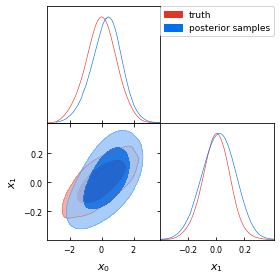

In [10]:
plot_triangles(q_samples, q_weights, Cov)

In [11]:
def sns_pairplot(q_samples, q_weights, truth_samples=None, q_label='q', 
                 truth_label='Truth', out_name=None, levels=10):
    
    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = np.empty(len(q_samples) + len(truth_samples), dtype=str)
        labels[:len(q_samples)] = q_label
        labels[len(q_samples):] = truth_label
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    else:
        labels = np.empty(len(q_samples), dtype=str)
        labels[:] = q_label
        x_samples = q_samples
        weights = q_weights
    
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    print(df)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.map_offdiag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name)

      labels     $x_0$     $x_1$
0          q -0.446628  0.174130
1          q  0.815186  0.035384
2          q  0.591422  0.139222
3          q -1.495104 -0.376949
4          q  3.163809  0.297893
...      ...       ...       ...
10045      T  0.510988  0.046074
10046      T -0.537798 -0.032829
10047      T  2.209297  0.193357
10048      T  2.174354  0.092499
10049      T -1.300648 -0.008011

[10050 rows x 3 columns]


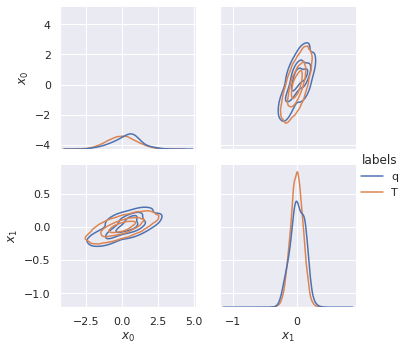

In [12]:
truth = n_mvn.rvs(mean=np.zeros(n), cov=Cov, size=10000)
sns_pairplot(q_samples, q_weights, truth, levels=4, out_name='./final_weighted_q_dla.png')

      labels     $x_0$     $x_1$
0          q -0.446628  0.174130
1          q  0.815186  0.035384
2          q  0.591422  0.139222
3          q -1.495104 -0.376949
4          q  3.163809  0.297893
...      ...       ...       ...
10045      T  0.510988  0.046074
10046      T -0.537798 -0.032829
10047      T  2.209297  0.193357
10048      T  2.174354  0.092499
10049      T -1.300648 -0.008011

[10050 rows x 3 columns]


KeyboardInterrupt: 

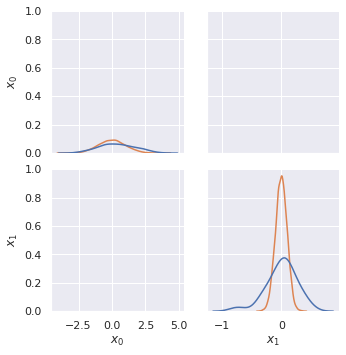

In [13]:
sns_pairplot(q_samples, np.ones(len(q_samples)), truth, levels=4, 
             out_name='./final_unweighted_q_dla.png')

In [ ]:
dla_samples = trace['mh_samples'][0]
dla_samples.keys()

In [ ]:
fkey = list(dla_samples.keys())[-1]
sns_pairplot(dla_samples[fkey], np.ones(len(dla_samples[fkey])), truth, levels=4)

# Nice plots for visualizing the DLA updates ...

In [15]:
dla_samples = trace['dla_samples'][0]
mh_samples = trace['mh_samples'][0]

In [16]:
def quiver_plot(init_samples, dla_updates, mh_updates, truth=None, q_samples=None, levels=4, out_name=None,
                figsize=(2 * 8.09, 2 * 5.0), markersize=10):
    
    dla_diff = dla_updates - init_samples

    mh_changed = np.where(dla_updates != mh_updates)[0]
    mh_updates = mh_updates[mh_changed]
    mh_diff = mh_updates - dla_updates[mh_changed]
    
    plt.figure(figsize=figsize)
    sns.set_theme()
    sns.scatterplot(init_samples[:, 0], init_samples[:, 1], label='Initial Positions', color='#332288',
                    marker="o", s=markersize)
    sns.scatterplot(dla_updates[:, 0], dla_updates[:, 1], label='DLA updates', color='#117733',
                    marker="v", s=markersize)
    sns.scatterplot(mh_updates[:, 0], mh_updates[:, 1], label='MH updates', color='#999933',
                    marker="D", s=markersize)
    plt.quiver(init_samples[:, 0], init_samples[:, 1], dla_diff[:, 0], dla_diff[:, 1], angles='xy',
               alpha=0.5, scale_units='xy', scale=1, color='#88CCEE', label='DLA vector')
    plt.quiver(dla_updates[:, 0][mh_changed], dla_updates[:, 1][mh_changed], mh_diff[:, 0], 
               mh_diff[:, 1], angles='xy', alpha=0.5, scale_units='xy', scale=1, color='#44AA99', 
               label='MH vector')
    if truth is not None:
        sns.kdeplot(truth[:, 0], truth[:, 1], label='Target', alpha=0.5, color='#DDCC77', levels=levels)
    if q_samples is not None:
        sns.kdeplot(q_samples[:, 0], q_samples[:, 1], label='q', alpha=0.5, color='#AA4499', levels=levels)
    plt.legend(loc=2, bbox_to_anchor=(1, 1))
    if out_name is not None:
        plt.savefig(out_name, bbox_inches='tight')

/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

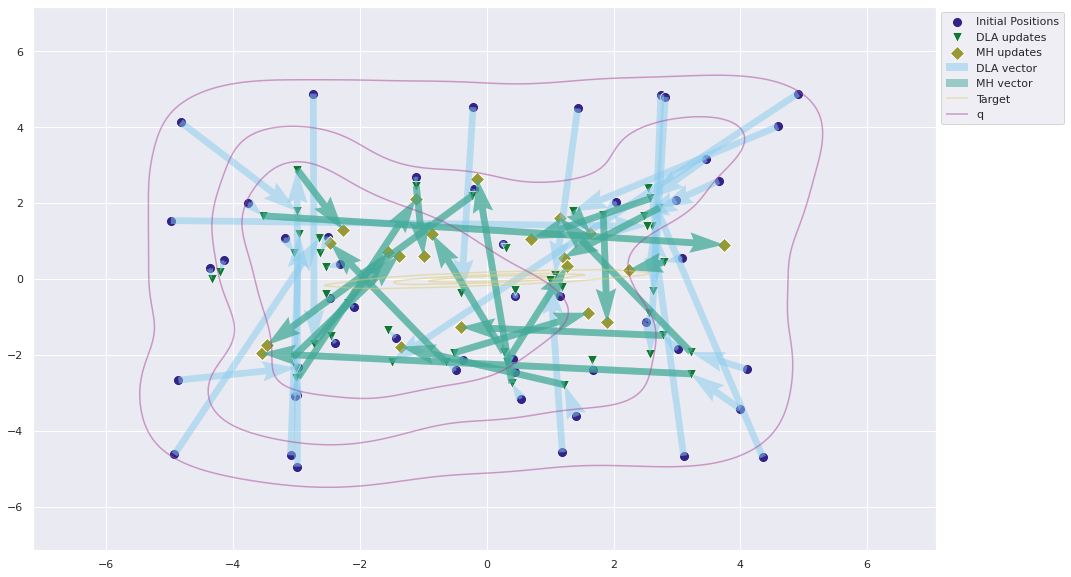

In [17]:
q = trace['dla_qmodels'][0]['burnin_0']
qx, _ = q.sample(2000, device='cpu')
qx = qx.numpy()

quiver_plot(jax_prior_init, dla_samples['burnin_0'], mh_samples['burnin_0'], truth, qx, markersize=100)

init_key = prior
Current key = burnin_0
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_0
Current key = burnin_1
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_1
Current key = burnin_2
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_2
Current key = burnin_3
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = burnin_3
Current key = burnin_4
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = post_burnin_0
Current key = DLA_1
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = DLA_1
Current key = DLA_2
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = DLA_2
Current key = DLA_3
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = DLA_3
Current key = DLA_4
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

init_key = DLA_4
Current key = DLA_5
shape init = (50, 2)
shape dla = (50, 2)
shape mh = (50, 2)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

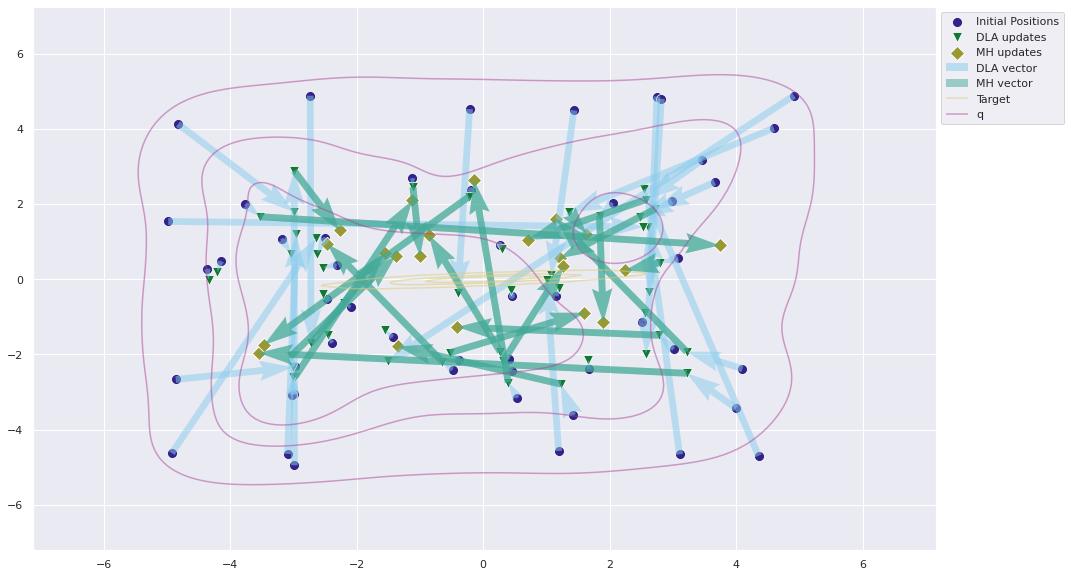

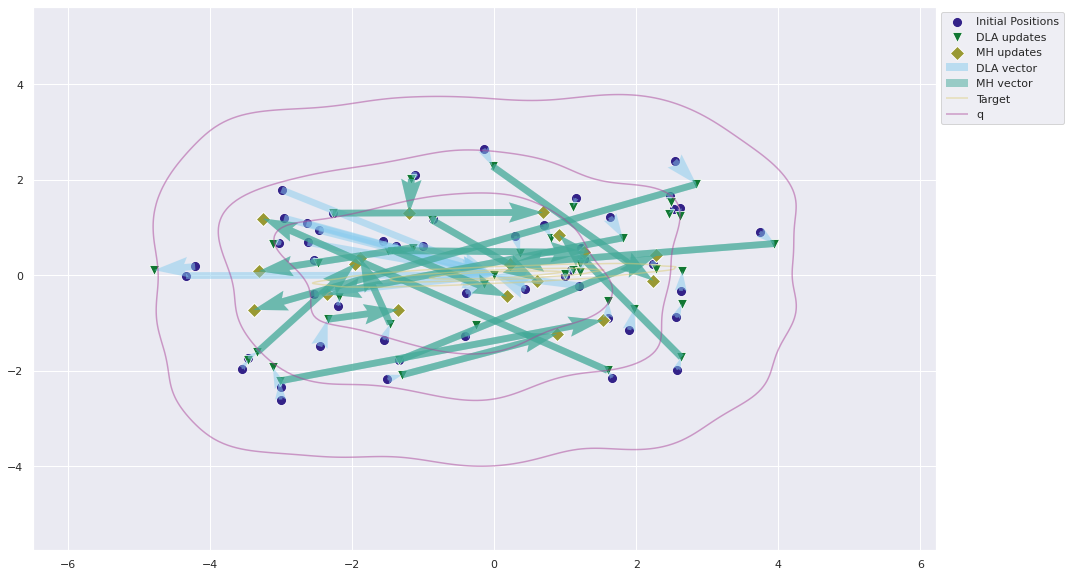

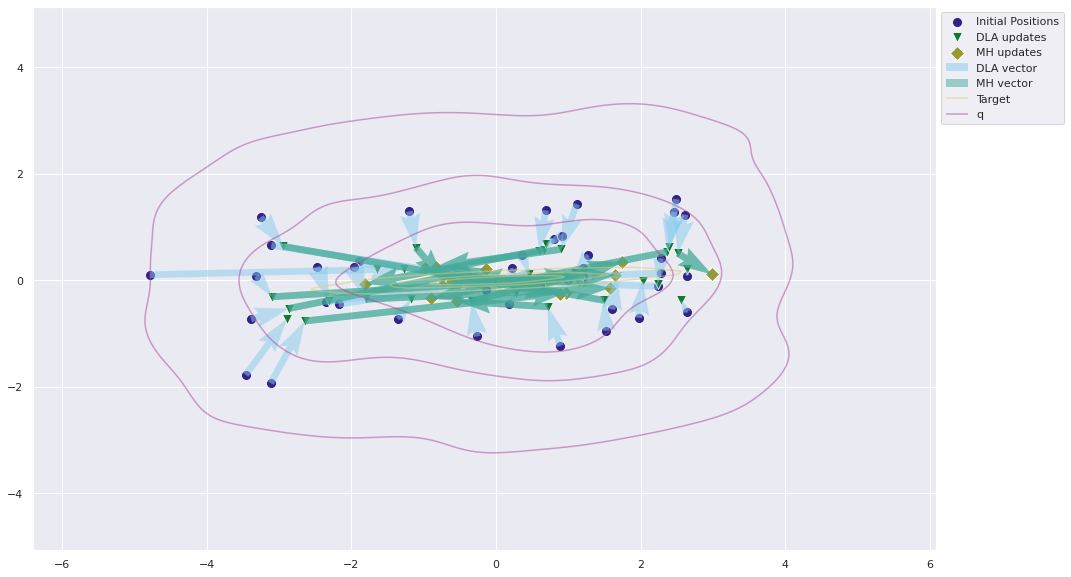

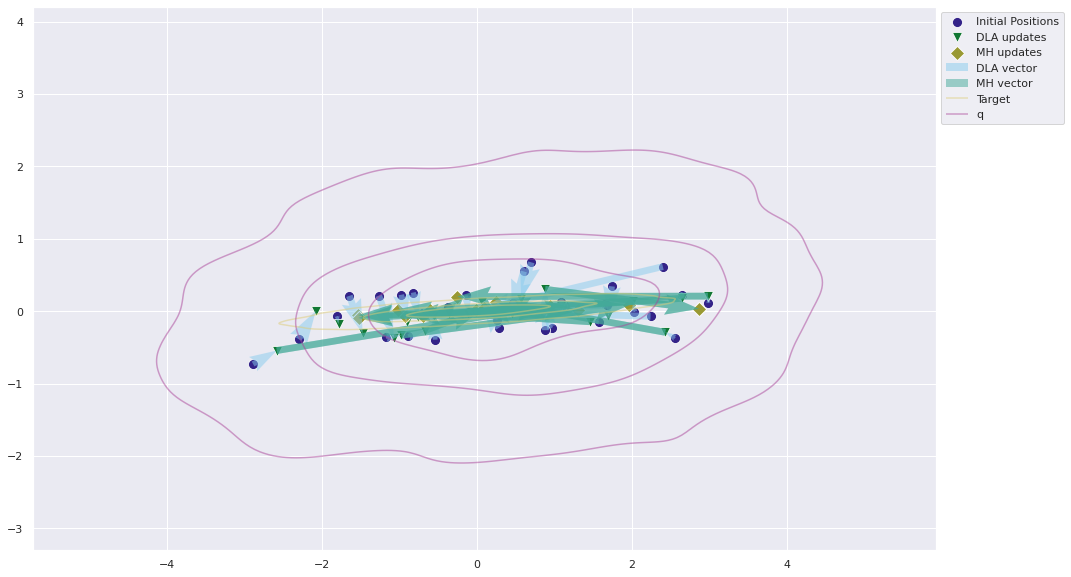

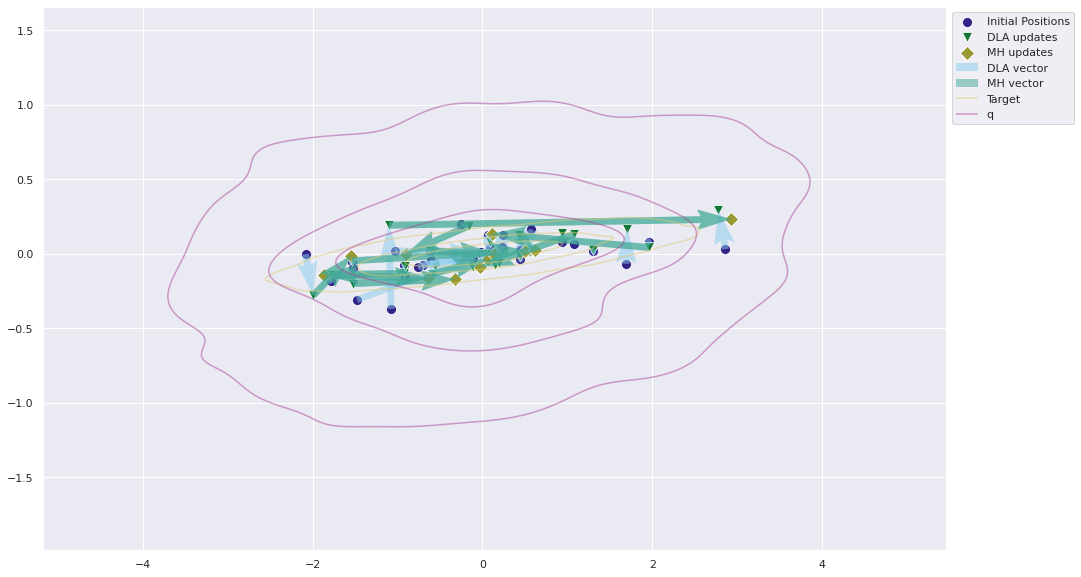

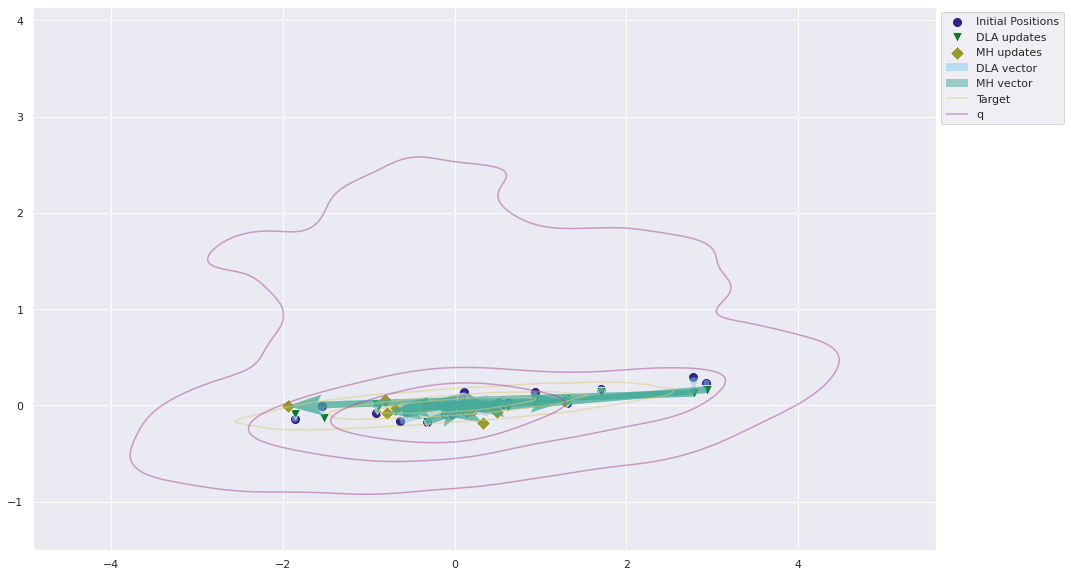

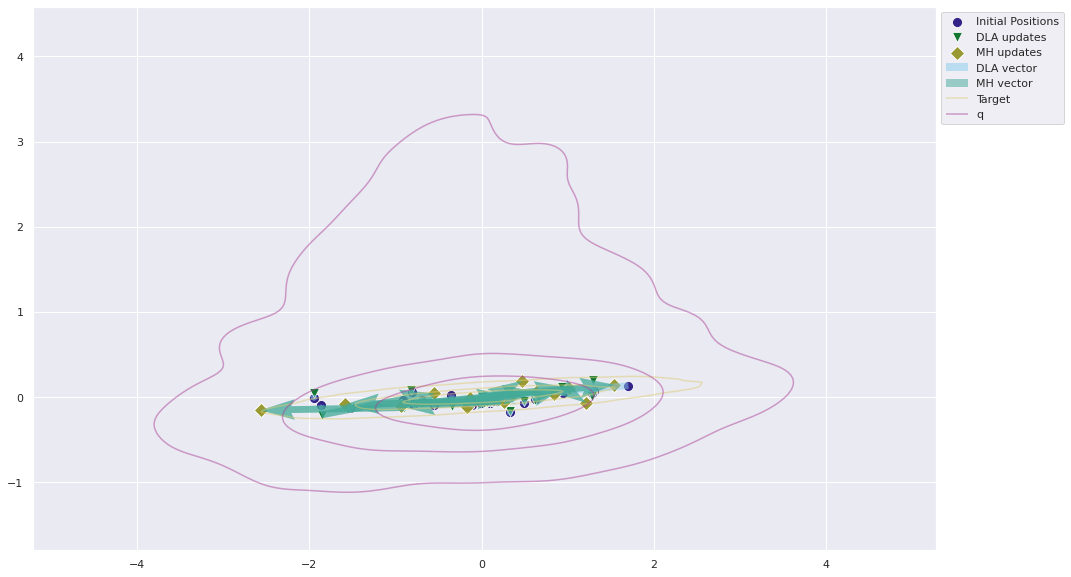

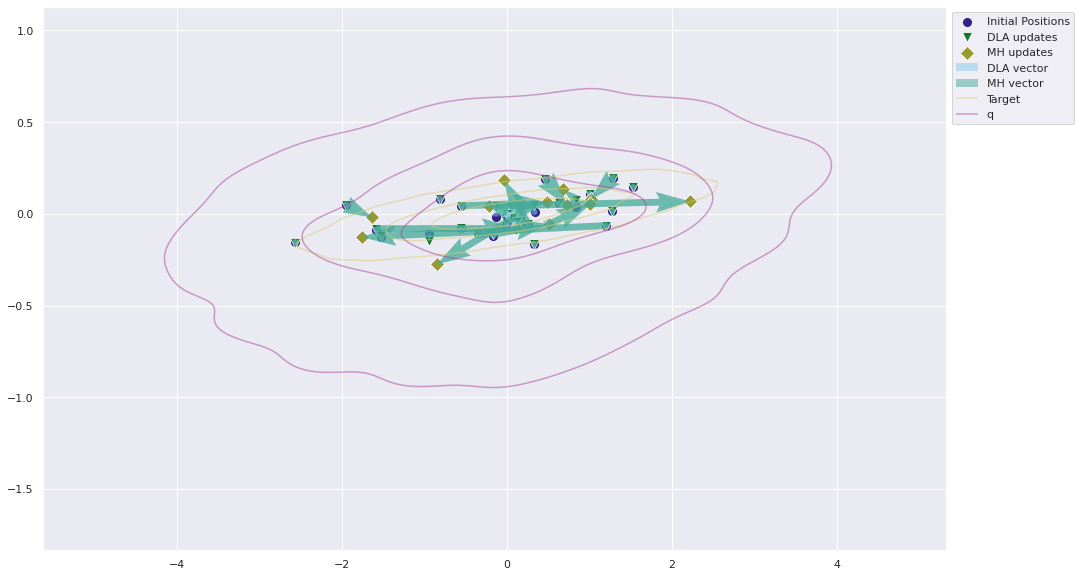

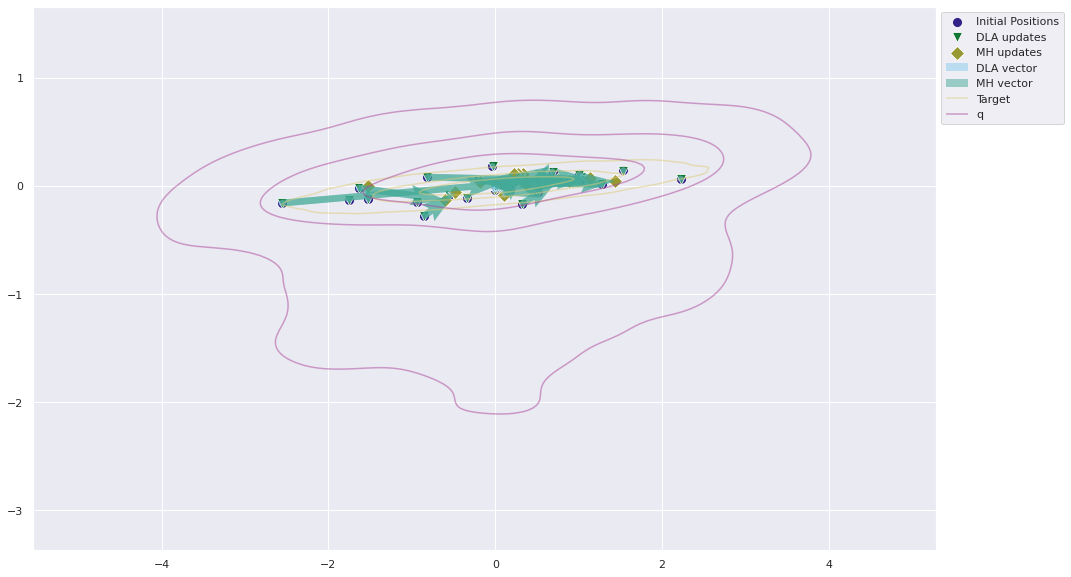

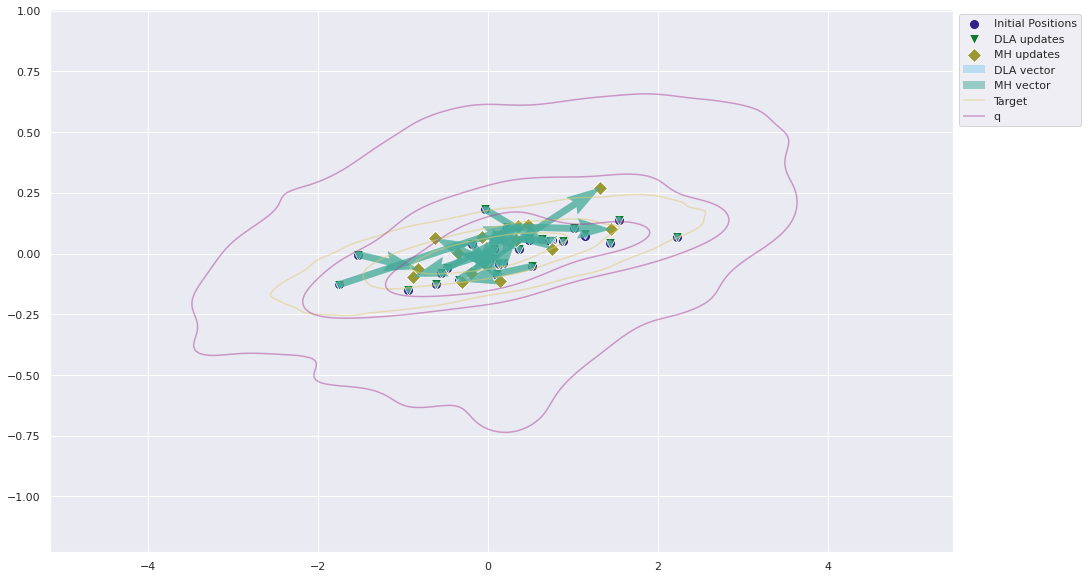

In [18]:
dla_samples = trace['dla_samples'][0]
mh_samples = trace['mh_samples'][0]
dla_keys = list(dla_samples.keys())



for i, key in enumerate(dla_keys):
    
    if key == 'post_burnin_0':
        continue
    
    if i == 0:
        print('init_key = prior')
        initial_samples = jax_prior_init
    elif i > 0:
        print(f'init_key = {dla_keys[i - 1]}')
        initial_samples = mh_samples[dla_keys[i - 1]]

    print(f'Current key = {key}')
    dla_updates = dla_samples[key]
    mh_updates = mh_samples[key]
    
    print(f'shape init = {np.shape(initial_samples)}')
    print(f'shape dla = {np.shape(dla_updates)}')
    print(f'shape mh = {np.shape(mh_updates)}')
    
    q = trace['dla_qmodels'][0][key]
    qx, _ = q.sample(2000, device='cpu')
    qx = qx.numpy()
    
    quiver_plot(initial_samples, dla_updates, mh_updates, truth, qx, markersize=100,
                levels=4, out_name=f'./dla_figs/dla_iteration_{key}.png')